# VKYN TensorFlow (EfficientNet)

For B0 to B7 base models, the input shapes are different. Here is a list of input shape expected for each model:

| Base model    | resolution |
|---------------|------------|
| EfficientNetB0 | 224        |
| EfficientNetB1 | 240        |
| EfficientNetB2 | 260        |
| EfficientNetB3 | 300        |
| EfficientNetB4 | 380        |
| EfficientNetB5 | 456        |
| EfficientNetB6 | 528        |
| EfficientNetB7 | 600        |

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from PIL import Image as pil
from PIL.Image import Image
from shutil import move, copy

from vkyn import *

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
tf.get_logger().setLevel("ERROR")

In [6]:
DATA = Path("data/vkyn01-dataset-binary")

In [7]:
print(DATA)

data\vkyn01-dataset-binary


In [8]:
# def create_dataset(path: Path, labels: bool = True) -> pd.DataFrame:
#     return pd.DataFrame([
#         {
#             "filename": file.name,
#             "label": file.parent.name if labels else None,
#         }
#         for file in path.glob("**/*.jpg")
#     ])

# df = create_dataset(DATA)
# df.sample(10, random_state=42)

In [9]:
SEED = 1337

IMAGE_SIZE = (300, 300) # EfficientNetB3
BATCH_SIZE = 128

# Keras will automatically create labels (0 - n, 1 - y)

training_images = tf.keras.utils.image_dataset_from_directory(
    DATA / "train",
    seed = SEED,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    crop_to_aspect_ratio=True,
)
validation_images = tf.keras.utils.image_dataset_from_directory(
    DATA / "val",
    seed = SEED,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    crop_to_aspect_ratio=True,
)
test_images = tf.keras.utils.image_dataset_from_directory(
    DATA / "train",
    seed = SEED,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    validation_split = 0.2,
    subset = "validation",
    crop_to_aspect_ratio=True,
)

Found 16605 files belonging to 2 classes.
Found 4158 files belonging to 2 classes.
Found 16605 files belonging to 2 classes.
Using 3321 files for validation.


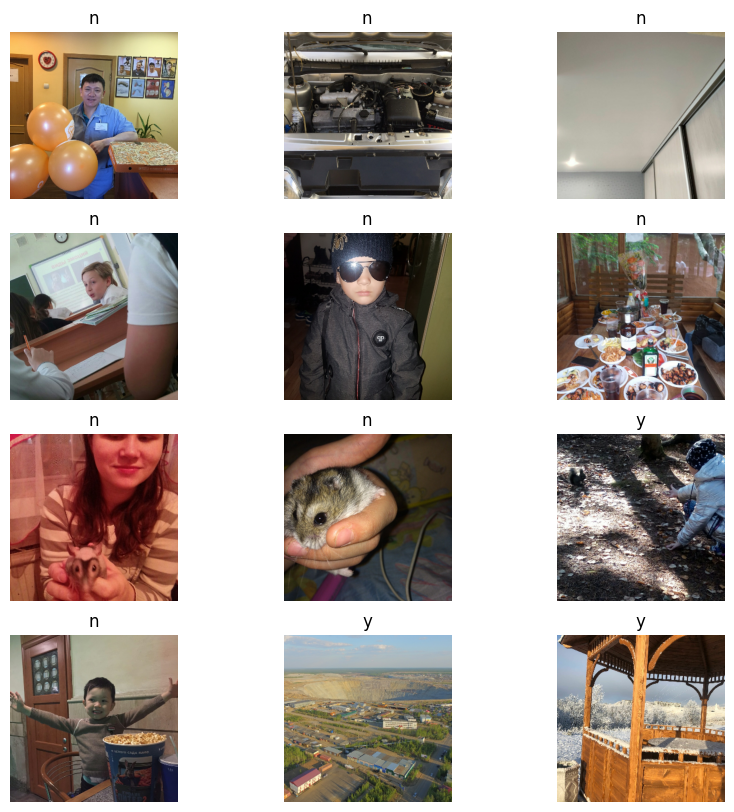

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in training_images.take(1):
    for i in range(12):
        label = training_images.class_names[int(labels[i])]
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(label)
        plt.axis("off")

In [11]:
with tf.device("/cpu:0"):
  image_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip("horizontal", seed=42),
      tf.keras.layers.RandomRotation(0.1),
      tf.keras.layers.RandomContrast(0.4, seed=42),
  ])

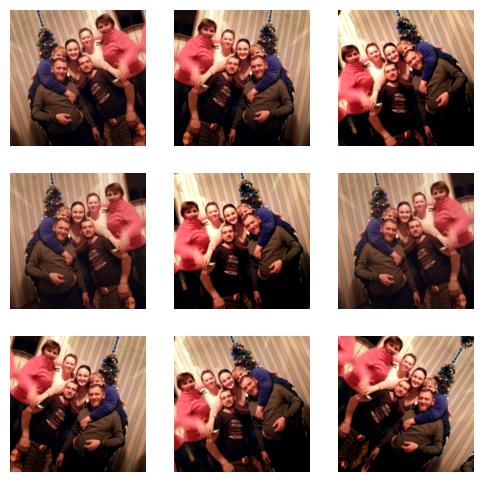

In [12]:
image, label = next(iter(training_images))

plt.figure(figsize=(6, 6))

for i in range(9):
    augmented_image = image_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  # ds = ds.map(lambda x, y: (image_augmentation(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (image_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  # prefetch may in some situation improve performance
  return ds.prefetch(buffer_size=AUTOTUNE)

In [14]:
training_images = prepare(training_images, shuffle=True, augment=True)
validation_images = prepare(validation_images)

In [15]:
def build_model(input_shape, num_classes: int, dropout_rate: float):
    inputs = tf.keras.layers.Input(shape=input_shape)
    cnn = tf.keras.applications.EfficientNetB3(
        input_tensor=inputs,
        include_top=False,
        weights="imagenet",
    )

    # Freeze the pretrained weights
    cnn.trainable = False

    # Rebuild top
    avg_pool = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(cnn.output)
    x = tf.keras.layers.BatchNormalization()(avg_pool)

    # Dropout
    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(dropout_rate, name="top_dropout")(x)

    # Output
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    outputs = tf.keras.layers.Dense(units, activation=activation, name="pred")(x)

    return tf.keras.Model(inputs, outputs, name="VKYN01"), (inputs, cnn, avg_pool, outputs)

In [16]:
# Create an instance of model
model, _ = build_model(
    input_shape=IMAGE_SIZE + (3,),
    num_classes=2,
    dropout_rate=0.3,
)

In [61]:
# Load weights in Keras format(h5)
# model.load_weights("./weights/vkyn01-tf-efficientnetb3_5_epochs_dropout_03_learningrate1e-3_epochs.keras")

In [32]:
# Visualize model
# tf.keras.utils.plot_model(model, show_shapes = True)

In [17]:
# We unfreeze the top N layers while leaving BatchNorm layers frozen
for layer in model.layers[-40:]:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        continue
    layer.trainable = True

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) # for training head layer

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
# model.summary()

In [ ]:
EPOCHS = 5
callbacks=[]

history = model.fit(
    training_images,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=validation_images,
)

Epoch 1/5
  6/130 ━━━━━━━━━━━━━━━━━━━━ 12:20 6s/step - accuracy: 0.6842 - loss: 0.6464

In [28]:
#model.save('weights/vkyn01-tf-efficientnetb3_latest.keras')
# Epoch 5/5
# 129/129 ━━━━━━━━━━━━━━━━━━━━ 122s 876ms/step - accuracy: 0.9865 - loss: 0.0371 - val_accuracy: 0.9662 - val_loss: 0.0986

# %tensorboard --logdir log_dir/name

In [ ]:
%time model.evaluate(test_images)

In [ ]:
def plot_accuracy(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


def plot_loss(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [ ]:
# print("epochs=20; 8k; LR=1e-4; size=384; EfficientNetV2-s ImageNet; with augmentation; dropout=0.25; train last 20 layers")
plot_accuracy(history)
plot_loss(history)

## Separate Images

In [12]:
SEED = 1337

IMAGE_SIZE = (300, 300) # EfficientNetB3
BATCH_SIZE = 128


In [10]:
def build_model(input_shape, num_classes: int, dropout_rate: float):
    inputs = tf.keras.layers.Input(shape=input_shape)
    cnn = tf.keras.applications.EfficientNetB3(
        input_tensor=inputs,
        include_top=False,
        weights="imagenet",
    )

    # Freeze the pretrained weights
    cnn.trainable = False

    # Rebuild top
    avg_pool = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(cnn.output)
    x = tf.keras.layers.BatchNormalization()(avg_pool)

    # Dropout
    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(dropout_rate, name="top_dropout")(x)

    # Output
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    outputs = tf.keras.layers.Dense(units, activation=activation, name="pred")(x)

    return tf.keras.Model(inputs, outputs, name="VKYN01"), (inputs, cnn, avg_pool, outputs)

In [13]:
# Create an instance of model
model, _ = build_model(
    input_shape=IMAGE_SIZE + (3,),
    num_classes=2,
    dropout_rate=0.3,
)

NameError: name 'tf' is not defined

In [67]:
# Load weights in Keras format(h5)
model.load_weights("./weights/vkyn01-tf-efficientnetb3_5_epochs_dropout_03_learningrate1e-3_epochs.keras")

In [5]:
def process_image(path: Path):
    img = tf.keras.preprocessing.image.load_img(path, target_size=IMAGE_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array

def predict_image(model, path: Path) -> dict[str, float]:
    img_array = process_image(path)
    predictions = model.predict(img_array, verbose=0)
    score = predictions[0][0]
    return {
        "y": score,
        "n": 1 - score,
    }

In [39]:
# vkyn01 = build_vkyn01()
# vkyn01.load_weights("weights/20250413-vkyn01.keras")

In [6]:
VaskaDataSetPath = "H:/Datasets/MagistracyDiploma/Images/vaska"

In [7]:
VaskaImagesLess02 = "H:/Datasets/MagistracyDiploma/Images/vaska_bad"

In [51]:
#predict_image(vkyn01, Path("/Users/tmshv/Downloads/DATA/SNDL_RANDOM_10000/-1813758_457269524.jpg"))

In [8]:
from pathlib import Path

for f in Path(VaskaDataSetPath).glob("*.jpg"):
    p = predict_image(model, f)
    if p["n"] > 0.8:
        print(f.name, p)
        move(f, VaskaImagesLess02)

NameError: name 'model' is not defined

In [139]:
BASE_VAL = Path("data/test00")
df_val = create_dataset(BASE_VAL)

predict = VkynPredictor(vkyn01, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
prediction = predict([
    BASE_VAL / row["label"] / row["filename"]
    for _, row in df_val.iterrows()
])

df_val["score"] = 0.0
for i, x in enumerate(df_val.iterrows()):
    score = prediction[i]["score"]
    df_val.loc[i, "score"] = float(score)
df_val.sample(10, random_state=42)

100%|███████████████████████████████████████████████████████████| 57/57 [05:42<00:00,  6.00s/it]


In [140]:
# x = df_val[(df_val["label"] == "y") & (df_val["score"] > 0.98)]
# x = df_val[(df_val["label"] == "n") & (df_val["score"] < 0.01)]

# false-negative: Y images labeled as N by model
# x = df_val[(df_val["label"] == "y") & (df_val["score"] < 0.5)]

# true-negative: N images labeled as Y by model
x = df_val[(df_val["label"] == "n") & (df_val["score"] > 0.5)]

to_base = Path("data/not-good")

for _, row in x.iterrows():
    f = BASE_VAL / str(row["label"]) / str(row["filename"])
    t = to_base / str(row["filename"])
    if not f.is_file():
        continue
    move(f, t)
x.shape 

,filename,label,score
1414,-123685490_457249302.jpg,n,0.000006
6459,353303684_457239357.jpg,y,0.999849
5960,391728498_456239394.jpg,y,0.999322
4075,197089281_457239115.jpg,y,0.999998
2457,280128535_457239907.jpg,y,0.999969
3540,23333841_457239317.jpg,y,0.953790
4578,359065863_457239049.jpg,y,0.999948
3425,352231819_456239809.jpg,y,0.997219
3813,74407129_456240464.jpg,y,0.998053
468,434990746_457259858.jpg,n,0.000059


In [147]:
# Making an inference

# Create model
vkyn01 = build_vkyn01()
vkyn01.load_weights("weights/20250413-vkyn01.keras")

# Take this directory
BASE_VAL = Path("data/korsakov00/")
df_val = create_dataset(BASE_VAL, labels=False)

# Make a prediction
predict = VkynPredictor(vkyn01, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
prediction = predict([
    BASE_VAL / row["filename"]
    for _, row in df_val.iterrows()
])

# Fill up the dataset
df_val["score"] = 0.0
for i, x in enumerate(df_val.iterrows()):
    score = prediction[i]["score"]
    df_val.loc[i, "score"] = float(score)

m = df_val["score"] <= 0.5
df_val.loc[m, "label"] = "n"

m = df_val["score"] > 0.5
df_val.loc[m, "label"] = "y"

df_val.sample(10, random_state=42)

100%|███████████████████████████████████████████████████████████| 68/68 [06:49<00:00,  6.03s/it]


,filename,label,score
4951,-75133008_457428925.jpg,n,0.000065
4825,133244995_457242971.jpg,n,0.000403
6741,112287158_457249197.jpg,n,0.000068
222,493935487_456239193.jpg,y,0.999907
5746,41763232_351359128.jpg,y,0.999987
6832,-70946666_457713868.jpg,n,0.000151
1084,556629905_457239018.jpg,n,0.000083
2758,36410109_456239141.jpg,n,0.000565
6459,710367249_457239174.jpg,y,1.000000
3459,528286482_457239494.jpg,n,0.000358


In [148]:
(BASE_VAL / "n").mkdir(exist_ok = True)
(BASE_VAL / "y").mkdir(exist_ok = True)

for _, row in df_val.iterrows():
    f = BASE_VAL / row["filename"]
    t = BASE_VAL / row["label"] / row["filename"]
    move(f, t)

In [149]:
# x = df_val[(df_val["label"] == "y") & (df_val["score"] > 0.025) & (df_val["score"] < 0.5)].sort_values(by="score", ascending=False)
# x = df_val[(df_val["label"] == "n") & (df_val["score"] > 0.5) & (df_val["score"] < 0.9)].sort_values(by="score", ascending=True)

x = df_val[(df_val["score"] > 0.3) & (df_val["score"] < 0.7)]
for _, row in x.iterrows():
    f = BASE_VAL / row["label"] / row["filename"]
    t = BASE_VAL / row["filename"]
    move(f, t)

## Find similar

In [189]:
vkyn01, parts = build_model(
    input_shape=IMAGE_SIZE + (3,),
    num_classes=2,
    dropout_rate=0
)
# vkyn01.load_weights("weights/vkyn01-tf-efficientnetb3.h5")
# vkyn01.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#     loss="binary_crossentropy",
#     metrics=["accuracy"],
# )
inputs, cnn, avg_pool, outputs = parts

# vkyn_topless = tf.keras.Model(inputs=inputs, outputs=cnn.outputs, name="VKYN-FE")
vkyn_topless = tf.keras.Model(inputs=inputs, outputs=avg_pool, name="VKYN-FE")
# vkyn_topless = tf.keras.Model(inputs=tf.keras.layers.Input(shape=IMAGE_SIZE + (3,)), outputs=vkyn01.layers[:-2], name="VKYN-FE")
    # inputs = tf.keras.layers.Input(shape=input_shape)
# vkyn_topless = tf.keras.Sequential([vkyn01.layers[:-1]])

In [243]:
class VkynFeaturesOutput:
    def __call__(self, path: Path, prediction):
        return {
            "path": path,
            "filename": path.name,
            "features": prediction,
        }

fe = VkynPredictor(
    model=vkyn_topless,
    image_size=IMAGE_SIZE,
    batch_size=64,
)
fe.output = VkynFeaturesOutput()

# features = fe(list(Path("data/train").glob("**/*.jpg")))
features = fe(list(Path("data/unlabeled_pool").glob("**/*.jpg")))

100%|██████████| 27/27 [03:24<00:00,  7.59s/it]


In [271]:
def image_grid(df):
    pad = 0
    plt.figure(figsize=(12, 12 + pad))
    for i, idrow in enumerate(df.iterrows()):
        _, row = idrow
        filename = row["filename"]
        dist = row["dist"]
        path = row["path"]
        if not path.is_file():
            continue
        image = pil.open(path)
        # image.crop()
        # image = resize_image(image, (300, 300))
        # ax = plt.subplot(4, 3, i + 1)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image)
        title = f"{filename}\n({dist:0.3f})"
        plt.title(title)
        plt.axis("off")

In [285]:
filename_1 = [
    "154868448_457247681.jpg"
][-1]
file_1 = Path("data/train") / "y" / filename_1
features_1 = fe([file_1])[0]["features"]


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


In [286]:
from scipy.spatial import distance

for x in features:
    if x["filename"] == img_1:
        features_1 = x["features"]
        break

metric = "cosine"
df_dist = pd.DataFrame([
    {
        "path": x["path"],
        "filename": x["filename"],
        "dist": distance.cdist([features_1], [x["features"]], metric)[0][0],
    }
    for x in features
])

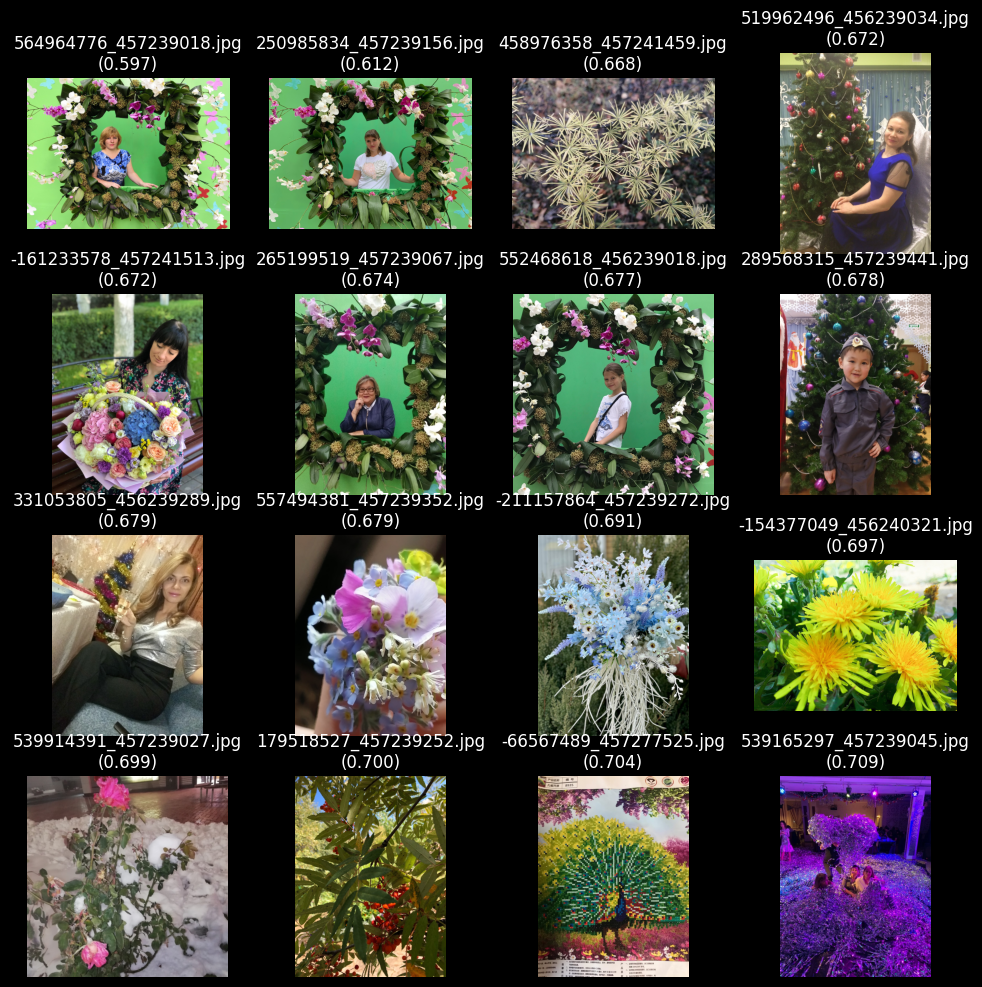

In [287]:
x = df_dist.sort_values(by="dist").head(16)
image_grid(x)

In [267]:
for i, row in x.iterrows():
    file = row["path"]
    p = predict_image(model, file)
    if p["y"] > 0.5:
        print(file)
        print(p)
        t = file.parent.parent
        move(file, t)

data/unlabeled_pool/125136744_457239150.jpg
{'y': 0.7275032, 'n': 0.2724968194961548}
data/unlabeled_pool/55394220_457240692.jpg
{'y': 0.87358946, 'n': 0.12641054391860962}
data/unlabeled_pool/143846224_456239563.jpg
{'y': 0.5771532, 'n': 0.42284679412841797}
data/unlabeled_pool/5599494_456239452.jpg
{'y': 0.59495836, 'n': 0.4050416350364685}


In [226]:
X = np.array([x["features"] for x in features])

In [245]:
from sklearn.neighbors import NearestNeighbors
# X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
nbrs = NearestNeighbors(n_neighbors=2, algorithm="ball_tree")
nbrs.fit(X)
distances, indices = nbrs.kneighbors(X, return_distance=True)

In [175]:
from sklearn.cluster  import DBSCAN

# best silhoette score
cluster = DBSCAN(
    metric="cosine",
    eps=0.55,
    min_samples=9,
)

# ...
cluster = DBSCAN(
    metric="cosine",
    eps=0.6,
    min_samples=19,
)
y_pred = cluster.fit_predict(X)

np.unique(y_pred)

array([-1,  0,  1])

In [176]:
from sklearn.metrics import silhouette_score

silhouette_score(X, cluster.labels_, metric="cosine", random_state=42)

0.104429886

In [174]:
for eps in np.arange(0.4, 1, step=0.02):
    for min_samples in np.arange(3, 20, step=1):
        # eps = 0.5
        m = DBSCAN(
            metric="cosine",
            eps=eps,
            min_samples=min_samples,
            # min_samples=5,
        )
        m.fit(X)
        clusters = np.unique(m.labels_).shape[0] - 1
        if clusters < 2:
            continue
        s = silhouette_score(X, m.labels_, metric="cosine", random_state=42)
        if s < 0.05:
            continue
        print(f"{eps=}")
        print(f"{min_samples=}")
        print(f"Clusters: {clusters}")
        print(f"Silhoette: {s}")
        # np.unique(cluster.labels_)

eps=0.5000000000000001
min_samples=8
Clusters: 4
Silhoette: 0.052243560552597046
eps=0.5000000000000001
min_samples=9
Clusters: 4
Silhoette: 0.05043577030301094
eps=0.5000000000000001
min_samples=13
Clusters: 4
Silhoette: 0.05226345732808113
eps=0.5000000000000001
min_samples=14
Clusters: 4
Silhoette: 0.05114305019378662
eps=0.5000000000000001
min_samples=15
Clusters: 5
Silhoette: 0.050413623452186584
eps=0.5200000000000001
min_samples=6
Clusters: 4
Silhoette: 0.0575157105922699
eps=0.5200000000000001
min_samples=13
Clusters: 3
Silhoette: 0.05582842975854874
eps=0.5200000000000001
min_samples=14
Clusters: 3
Silhoette: 0.055855296552181244
eps=0.5200000000000001
min_samples=15
Clusters: 3
Silhoette: 0.05530766025185585
eps=0.5200000000000001
min_samples=16
Clusters: 3
Silhoette: 0.0632535070180893
eps=0.5200000000000001
min_samples=17
Clusters: 3
Silhoette: 0.06297487765550613
eps=0.5200000000000001
min_samples=18
Clusters: 3
Silhoette: 0.0620868057012558
eps=0.5200000000000001
min_samp

In [177]:
from sklearn.metrics import davies_bouldin_score

davies_bouldin_score(X, cluster.labels_)

5.157021119321508

In [178]:
df_cluster = pd.DataFrame([
    {
        "filename": x["filename"],
        "cluster": cluster.labels_[i],
    }
    for i, x in enumerate(ps)
])
df_cluster.set_index("filename", inplace=True)
df_cluster["label"] = df.set_index("filename")["label"]

<AxesSubplot: >

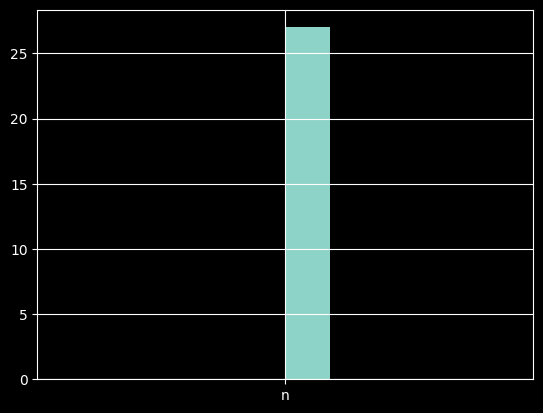

In [183]:
x = df_cluster[df_cluster["cluster"] == -1]
# x = df_cluster[df_cluster["cluster"] == 0]

x = df_cluster[(df_cluster["cluster"] == 1) & (df_cluster["label"] == "n")]
for filename, row in x.iterrows():
    f = DATA / row["label"] / filename
    # print(f.is_file())
    copy(f, "data/cluster")
x["label"].hist()

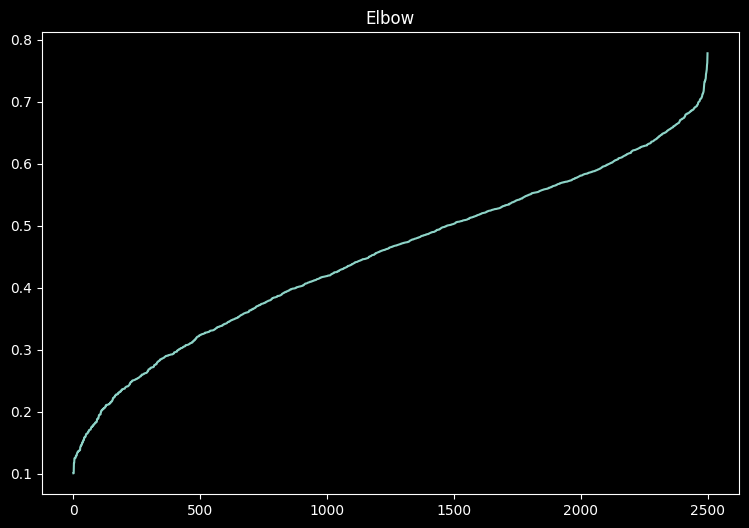

In [57]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2, metric="cosine")
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.figure(figsize=(9, 6))
plt.title(f"Elbow")
plt.plot(distances)

In [150]:
from sklearn.manifold import TSNE

In [ ]:
vkyn01 = build_vkyn01()
vkyn01.load_weights("vkyn01-checkpoints/epoch_9.keras")

/Users/tmshv/Work/vkyn/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


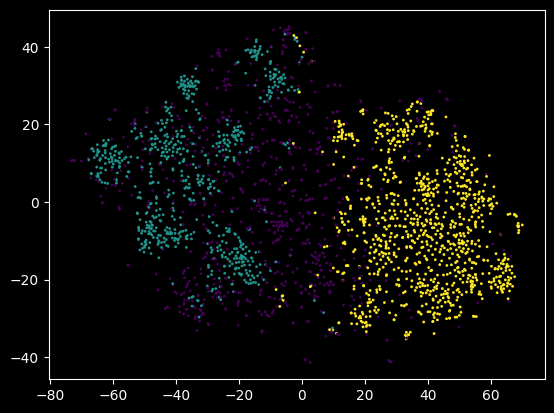

In [179]:
tsne = TSNE(
    n_components=2,
    init="pca",
    # perplexity=10,
    learning_rate=100,
    metric="cosine",
    n_jobs=-1,
)
x = tsne.fit_transform(X)

plt.scatter(x=x[:, 0], y=x[:, 1], s=1, c=y_pred)